In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Define base path for all operations
BASE_PATH = os.getcwd()
BASE_PATH

'/home/gadmicha/Regression'

In [3]:
all_organelles = ["Nucleolus-(Granular-Component)", "Nuclear-envelope", "Mitochondria", "Actin-filaments",
                 "Endoplasmic-reticulum", "Plasma-membrane", "Microtubules", "DNA"]
organelle = all_organelles[0]

In [4]:
# Load errors+error_predictions
error_predictions = np.load(f"{BASE_PATH}/Variables/{organelle}_Error_Predictions_Mask_Pred.npy")
errors = np.load(f"{BASE_PATH}/Variables/{organelle}_Errors.npy")

In [5]:
pcc_predictions = 1 - error_predictions
pccs = 1 - errors

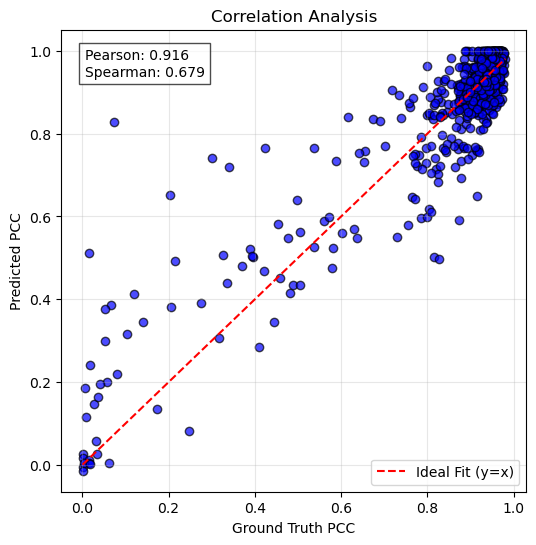

In [6]:
# Correlation
plt.figure(figsize=(6, 6))
plt.scatter(pccs, pcc_predictions, alpha=0.7, color="blue", edgecolors='k')
plt.plot([min(pccs), max(pccs)], [min(pccs), max(pccs)], 'r--', label="Ideal Fit (y=x)")

# Correlation coefficients
pearson_corr, _ = pearsonr(pccs, pcc_predictions)
spearman_corr, _ = spearmanr(pccs, pcc_predictions)
plt.text(0.05, 0.9, f"Pearson: {pearson_corr:.3f}\nSpearman: {spearman_corr:.3f}",
         transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel("Ground Truth PCC")
plt.ylabel("Predicted PCC")
plt.title("Correlation Analysis")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

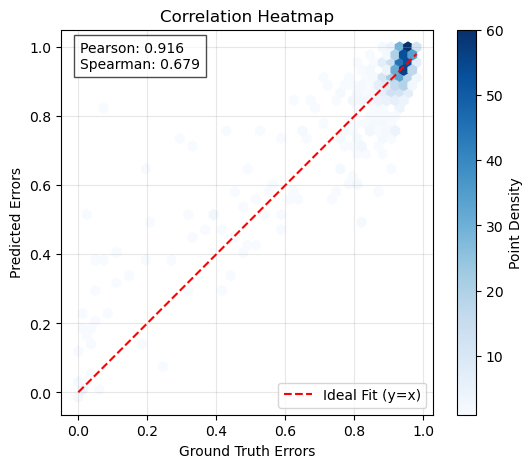

In [7]:
plt.figure(figsize=(6, 5))
hb = plt.hexbin(pccs, pcc_predictions, gridsize=40, cmap='Blues', mincnt=1)
plt.colorbar(hb, label='Point Density')

# Add correlation text
plt.text(0.05, 0.9, f"Pearson: {pearson_corr:.3f}\nSpearman: {spearman_corr:.3f}",
         transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

plt.plot([min(pccs), max(pccs)], [min(pccs), max(pccs)], 'r--', label="Ideal Fit (y=x)")
plt.xlabel("Ground Truth Errors")
plt.ylabel("Predicted Errors")
plt.title("Correlation Heatmap")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f"{BASE_PATH}/Outputs/{organelle} correlation heatmap.png", bbox_inches='tight')
plt.show()


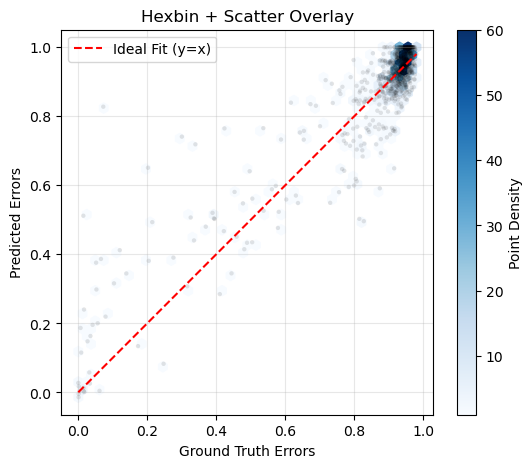

In [8]:
plt.figure(figsize=(6, 5))

# Hexbin for density
hb = plt.hexbin(pccs, pcc_predictions, gridsize=40, cmap='Blues', mincnt=1)

# Overlay raw points with low alpha to highlight sparse areas
plt.scatter(pccs, pcc_predictions, color='black', s=10, alpha=0.1, edgecolors='none')

# Reference line and text
plt.plot([min(pccs), max(pccs)], [min(pccs), max(pccs)], 'r--', label="Ideal Fit (y=x)")
plt.xlabel("Ground Truth Errors")
plt.ylabel("Predicted Errors")
plt.title("Hexbin + Scatter Overlay")
plt.legend()
plt.colorbar(hb, label='Point Density')
plt.grid(alpha=0.3)
plt.savefig(f"{BASE_PATH}/Outputs/{organelle} scatter hexbin.png", bbox_inches='tight')
plt.show()


In [9]:
# Create bins
bins = []
bins_images = []
for i in range(1,11):
    bins.append([])
    j = i/10
    for k in range(len(pccs)):
        if j-0.1 < pccs[k] < j:
            bins[i-1].append((pccs[k], pcc_predictions[k]))

In [10]:
gt_values = []
pred_values = []

for bin_data in bins:
    if bin_data:  # Skip empty bins
        gt, preds = zip(*bin_data)  # Separate GT and predictions
        gt_values.extend(gt)
        pred_values.extend(preds)

# Convert to numpy arrays
gt_values = np.array(gt_values)
pred_values = np.array(pred_values)

# Calculate global loss metrics
mae = np.mean(np.abs(gt_values - pred_values))  # Mean Absolute Error
mse = np.mean((gt_values - pred_values) ** 2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print results
print(f"Global MAE: {mae:.4f}")
print(f"Global MSE: {mse:.4f}")
print(f"Global RMSE: {rmse:.4f}")

Global MAE: 0.0483
Global MSE: 0.0061
Global RMSE: 0.0782


In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error

true_values = pccs.copy()
predictions = pcc_predictions.copy()
B = 1000
rng = np.random.default_rng(42)  # reproducible

# 1) Observed statistic
T_obs = mean_squared_error(true_values, predictions)  # lower is better

# 2) Permutation null (permute pairing between y_true and y_pred)
permuted = np.empty(B)
for b in range(B):
    y_true_perm = rng.permutation(true_values)
    permuted[b] = mean_squared_error(y_true_perm, predictions)

# 3) One-sided p with add-one rule (count ties as as-extreme)
hits = np.sum(permuted <= T_obs)
p_hat = (hits + 1) / (B + 1)

# 4) Helpful extras
null_mean = permuted.mean()
null_std  = permuted.std(ddof=1)
delta_mse = null_mean - T_obs            # absolute improvement vs null
z_score   = (T_obs - null_mean) / null_std  # standardized extremeness

print(f"Observed MSE: {T_obs:.6f}")
print(f"Perm-test p-value: {p_hat:.6g}  (B={B})")
print(f"ΔMSE vs null mean: {delta_mse:.6f}")
print(f"z-score vs null: {z_score:.2f}")


Observed MSE: 0.006120
Perm-test p-value: 0.000999001  (B=1000)
ΔMSE vs null mean: 0.063042
z-score vs null: -27.18


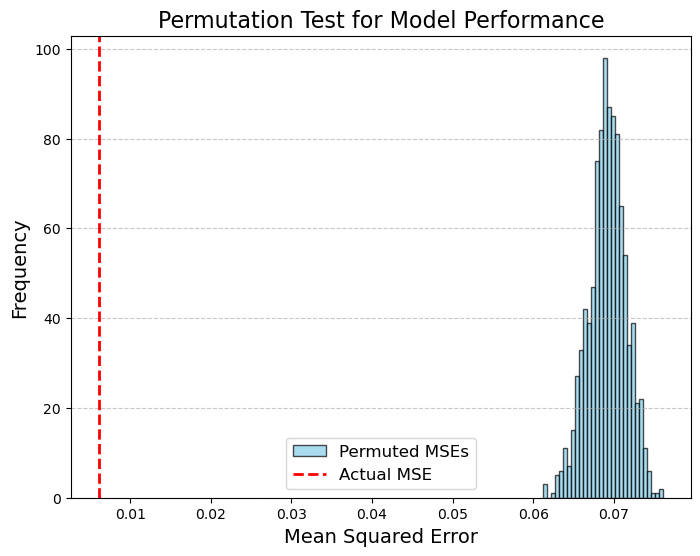

In [12]:
# Plot the histogram of permuted MSEs
plt.figure(figsize=(8, 6))
plt.hist(permuted, bins=30, color='skyblue', edgecolor='black', alpha=0.7, label="Permuted MSEs")
plt.axvline(mse, color='red', linestyle='--', linewidth=2, label="Actual MSE")
plt.title("Permutation Test for Model Performance", fontsize=16)
plt.xlabel("Mean Squared Error", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

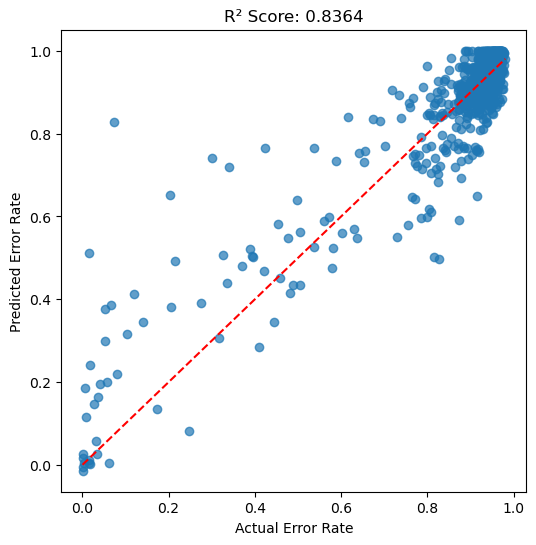

In [13]:
r2 = r2_score(pccs, pcc_predictions)
plt.figure(figsize=(6, 6))
plt.scatter(pccs, pcc_predictions, alpha=0.7)
plt.plot([min(pccs), max(pccs)], [min(pccs), max(pccs)], color='red', linestyle='--')
plt.xlabel("Actual Error Rate")
plt.ylabel("Predicted Error Rate")
plt.title(f"R² Score: {r2:.4f}")
plt.show()

In [14]:
from scipy import stats
from sklearn.neighbors import KernelDensity, NearestNeighbors
import warnings
import numbers

figure_config = {
    "title":20,
    "organelle":16,
    "text":10,
    "axis":10,
    "subtitle":12,
    "font":"DejaVu Sans"
}

def dermi_kde(x, y, x_col="Feature1",y_col="Feature2", n_bins=20, n_mesh=3, plot=True, save=False, title=""):
    """Compute Density Resampled Estimate of Mutual Information using KDE."""
    x, y = _vector_coerce_two_dense(x, y)

    if np.count_nonzero(x - x[0]) == 0 or np.count_nonzero(y - y[0]) == 0:
        warnings.warn(
            "Attempting to calculate DREMI on a constant array. Returning `0`",
            UserWarning,
        )
        return 0

    # Z-score X and Y
    x = np.clip(stats.zscore(x),-5,5)
    y = np.clip(stats.zscore(y),-5,5)

    # Create bin and mesh points
    x_bins = np.linspace(min(x), max(x), n_bins + 1)
    y_bins = np.linspace(min(y), max(y), n_bins + 1)
    x_mesh = np.linspace(min(x), max(x), ((n_mesh + 1) * n_bins) + 1)
    y_mesh = np.linspace(min(y), max(y), ((n_mesh + 1) * n_bins) + 1)

    # Perform joint density estimation using KDE
    data_subset = np.vstack([x, y])
    kde_joint = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data_subset.T)

    # Evaluate joint density on the mesh points
    mesh_points = np.vstack(
        [np.tile(x_mesh, len(y_mesh)), np.repeat(y_mesh, len(x_mesh))]
    ).T
    log_joint_density = kde_joint.score_samples(mesh_points)
    joint_density = np.exp(log_joint_density)

    # Sum the densities of each point over the bins
    bin_density, _, _ = np.histogram2d(
        mesh_points[:, 0],
        mesh_points[:, 1],
        bins=[x_bins, y_bins],
        weights=joint_density,
    )
    bin_density = bin_density.T
    bin_density = bin_density / np.sum(bin_density)

    # Compute conditional density estimate of Y given X
    conditional_density = bin_density / np.sum(bin_density, axis=0)
    
    # Rescale each column by its maximum value
    column_max = np.max(conditional_density, axis=0)
    rescaled_density = conditional_density / column_max

    # Mutual information
    marginal_entropy = stats.entropy(np.sum(bin_density, axis=1), base=2)
    cond_entropies = stats.entropy(conditional_density, base=2)
    cond_sums = np.sum(bin_density, axis=0)
    conditional_entropy = np.sum(cond_entropies * cond_sums)
    mutual_info = marginal_entropy - conditional_entropy

    # DREMI
    marginal_entropy_norm = stats.entropy(np.sum(conditional_density, axis=1), base=2)
    cond_sums_norm = np.mean(conditional_density)
    conditional_entropy_norm = np.sum(cond_entropies * cond_sums_norm)
    dremi = marginal_entropy_norm - conditional_entropy_norm

    if plot:
        fig, axes = plt.subplots(1, 4, figsize=(12, 2.5)) # (12,4) for notebook, (12,2.5) for saving
    
        # Plot raw data
        axes[0].scatter(x, y, c="k", s=4)
        axes[0].set_title("Raw scores", fontsize=10, fontname=figure_config["font"])
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        axes[0].set_xlabel(x_col, fontsize=figure_config["axis"], fontname=figure_config["font"])
        axes[0].set_ylabel(y_col, fontsize=figure_config["axis"], fontname=figure_config["font"])

        # Plot KDE joint density
        n = ((n_mesh + 1) * n_bins) + 1
        axes[1].imshow(
            joint_density.reshape(n, n), cmap="inferno", origin="lower", aspect="auto"
        )
        for b in np.linspace(0, n, n_bins + 1):
            axes[1].axhline(b - 0.5, c="grey", linewidth=1)
        for b in np.linspace(0, n, n_bins + 1):
            axes[1].axvline(b - 0.5, c="grey", linewidth=1)
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        axes[1].set_title("KDE Density", fontsize=10, fontname=figure_config["font"])
        axes[1].set_xlabel(x_col, fontsize=figure_config["axis"], fontname=figure_config["font"])

        # Plot joint probability
        axes[2].imshow(bin_density, cmap="inferno", origin="lower", aspect="auto")
        axes[2].set_xticks([])
        axes[2].set_yticks([])
        axes[2].set_title("Joint Prob.[MI={:.2f}]".format(mutual_info), fontsize=10, fontname=figure_config["font"])
        axes[2].set_xlabel(x_col, fontsize=figure_config["axis"], fontname=figure_config["font"])

        # Plot conditional probability
        axes[3].imshow(rescaled_density, cmap="inferno", origin="lower", aspect="auto")
        axes[3].set_xticks([])
        axes[3].set_yticks([])
        axes[3].set_title("Conditional Prob.[DREMI={:.2f}]".format(dremi), fontsize=10, fontname=figure_config["font"])
        axes[3].set_xlabel(x_col, fontsize=figure_config["axis"], fontname=figure_config["font"])

        if save:
            # Save plot
            plt.savefig(f"{BASE_PATH}/Outputs/{organelle} DREMI KDE.png", bbox_inches='tight')

        fig.suptitle(title, fontsize=figure_config["organelle"],fontname=figure_config["font"],y=0.92)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    return dremi

def dermi_knn(x, y, x_col="Feature1",y_col="Feature2",k=10, n_bins=20, n_mesh=3, n_jobs=1, plot=False,title=""):
    """Compute kNN conditional Density Resampled Estimate of Mutual Information."""
    x, y = _vector_coerce_two_dense(x, y)

    if np.count_nonzero(x - x[0]) == 0 or np.count_nonzero(y - y[0]) == 0:
        warnings.warn(
            "Attempting to calculate kNN-DREMI on a constant array. Returning `0`",
            UserWarning,
        )
        return -1

    if not isinstance(k, numbers.Integral):
        raise ValueError("Expected k as an integer. Got {}".format(type(k)))
    if not isinstance(n_bins, numbers.Integral):
        raise ValueError("Expected n_bins as an integer. Got {}".format(type(n_bins)))
    if not isinstance(n_mesh, numbers.Integral):
        raise ValueError("Expected n_mesh as an integer. Got {}".format(type(n_mesh)))

    # Z-score X and Y
    x = np.clip(stats.zscore(x),-5,5)
    y = np.clip(stats.zscore(y),-5,5)

    # Create bin and mesh points
    x_bins = np.linspace(min(x), max(x), n_bins + 1)
    y_bins = np.linspace(min(y), max(y), n_bins + 1)
    x_mesh = np.linspace(min(x), max(x), ((n_mesh + 1) * n_bins) + 1)
    y_mesh = np.linspace(min(y), max(y), ((n_mesh + 1) * n_bins) + 1)

    mesh_points = np.vstack(
        [np.tile(x_mesh, len(y_mesh)), np.repeat(y_mesh, len(x_mesh))]
    ).T

    knn = NearestNeighbors(n_neighbors=k, n_jobs=n_jobs).fit(np.vstack([x, y]).T)
    dists, _ = knn.kneighbors(mesh_points)

    area = np.pi * (dists[:, -1] ** 2)
    density = k / (area + 1e-10)  # Add small constant to avoid division by zero

    mesh_mask = np.logical_or(
        np.isin(mesh_points[:, 0], x_bins), np.isin(mesh_points[:, 1], y_bins)
    )
    bin_density, _, _ = np.histogram2d(
        mesh_points[~mesh_mask, 0],
        mesh_points[~mesh_mask, 1],
        bins=[x_bins, y_bins],
        weights=density[~mesh_mask],
    )
    bin_density = bin_density.T
    bin_density = bin_density / np.sum(bin_density)

    drevi = bin_density / np.sum(bin_density, axis=0)
    cond_entropies = stats.entropy(drevi, base=2)

    marginal_entropy = stats.entropy(np.sum(bin_density, axis=1), base=2)
    cond_sums = np.sum(bin_density, axis=0)
    conditional_entropy = np.sum(cond_entropies * cond_sums)
    mutual_info = marginal_entropy - conditional_entropy

    marginal_entropy_norm = stats.entropy(np.sum(drevi, axis=1), base=2)
    cond_sums_norm = np.mean(drevi)
    conditional_entropy_norm = np.sum(cond_entropies * cond_sums_norm)

    dremi = marginal_entropy_norm - conditional_entropy_norm

    if plot:
        fig, axes = plt.subplots(1, 4, figsize=(12, 4))
        
        # Plot raw data
        axes[0].scatter(x, y, c="k", s=4)
        axes[0].set_title("Raw scores",fontsize=14, fontname=figure_config["font"])
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        axes[0].set_xlabel(x_col, fontsize=figure_config["axis"], fontname=figure_config["font"])
        axes[0].set_ylabel(y_col, fontsize=figure_config["axis"], fontname=figure_config["font"])

        # Plot kNN density
        n = ((n_mesh + 1) * n_bins) + 1
        axes[1].imshow(
            np.log(density.reshape(n, n)), cmap="inferno", origin="lower", aspect="auto"
        )
        for b in np.linspace(0, n, n_bins + 1):
            axes[1].axhline(b - 0.5, c="grey", linewidth=1)

        for b in np.linspace(0, n, n_bins + 1):
            axes[1].axvline(b - 0.5, c="grey", linewidth=1)

        axes[1].set_xticks([])
        axes[1].set_yticks([])
        axes[1].set_title("kNN Density", fontsize=14, fontname=figure_config["font"])
        axes[1].set_xlabel(x_col, fontsize=figure_config["axis"], fontname=figure_config["font"])

        # Plot joint probability
        axes[2].imshow(bin_density, cmap="inferno", origin="lower", aspect="auto")
        axes[2].set_xticks([])
        axes[2].set_yticks([])
        axes[2].set_title(
            "Joint Prob.[MI={:.2f}]".format(mutual_info), fontsize=14, fontname=figure_config["font"]
        )
        axes[2].set_xlabel(x_col, fontsize=figure_config["axis"], fontname=figure_config["font"])

        # Plot conditional probability
        axes[3].imshow(drevi, cmap="inferno", origin="lower", aspect="auto")
        axes[3].set_xticks([])
        axes[3].set_yticks([])
        axes[3].set_title(
            "Conditional Prob.[DREMI={:.2f}]".format(dremi), fontsize=14, fontname=figure_config["font"]
        )
        axes[3].set_xlabel(x_col, fontsize=figure_config["axis"], fontname=figure_config["font"])

        fig.suptitle(title, fontsize=figure_config["organelle"], fontname=figure_config["font"],y=0.92)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

        return dremi

def _vector_coerce_two_dense(x, y):
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    if len(x) != len(y):
        raise ValueError("Expected x and y to be the same length. Got {} and {}".format(len(x), len(y)))
    return x, y


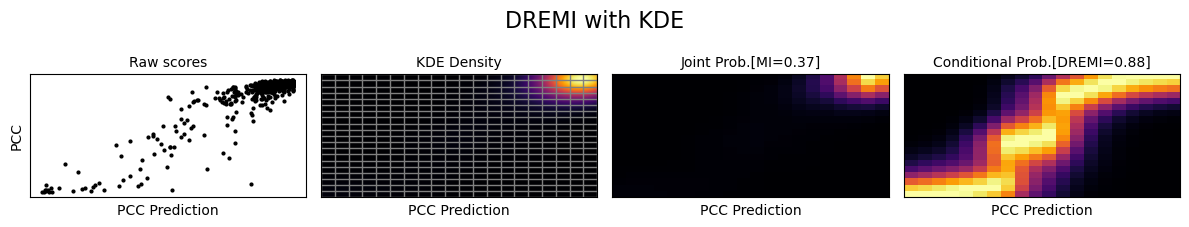

In [15]:
# Plot DREMI with KDE and kNN-DREMI
dremi_value_kde = dermi_kde(1-error_predictions, 1-errors, "PCC Prediction", "PCC", n_bins=20, n_mesh=10, plot=True, save=True, title="DREMI with KDE")

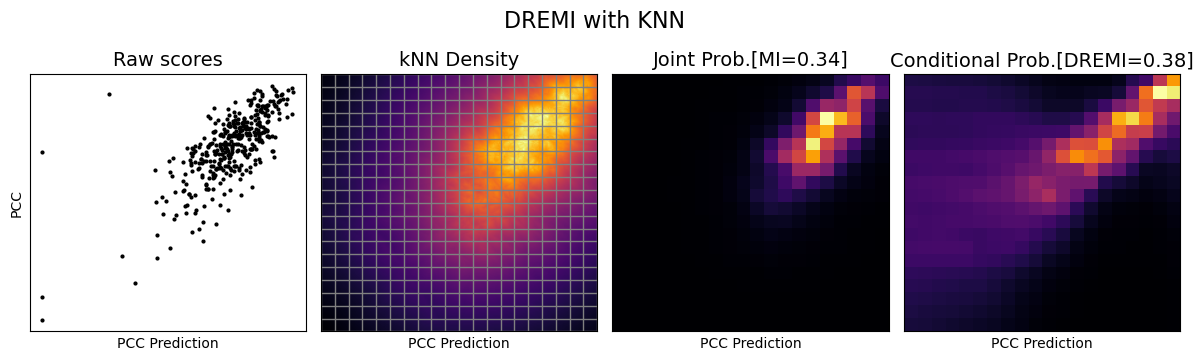

In [158]:
dremi_value_knn = dermi_knn(1-error_predictions, 1-errors, "PCC Prediction", "PCC", k=12, n_bins=20, n_mesh=10, n_jobs=2, plot=True,title="DREMI with KNN")

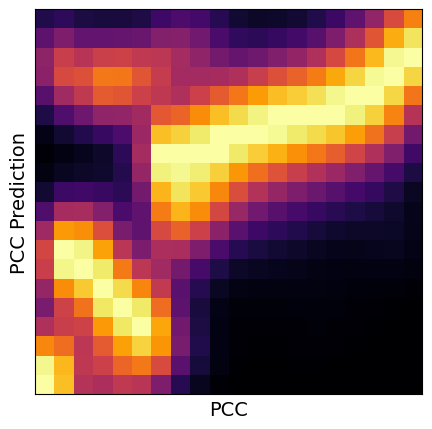

In [20]:
def dermi_new(x, y, x_col="Feature1",y_col="Feature2", n_bins=20, n_mesh=3, plot=True, save=False, title=""):
    """Compute Density Resampled Estimate of Mutual Information using KDE."""
    x, y = _vector_coerce_two_dense(x, y)

    if np.count_nonzero(x - x[0]) == 0 or np.count_nonzero(y - y[0]) == 0:
        warnings.warn(
            "Attempting to calculate DREMI on a constant array. Returning `0`",
            UserWarning,
        )
        return 0

    # Z-score X and Y
    x = np.clip(stats.zscore(x),-5,5)
    y = np.clip(stats.zscore(y),-5,5)

    # Create bin and mesh points
    x_bins = np.linspace(min(x), max(x), n_bins + 1)
    y_bins = np.linspace(min(y), max(y), n_bins + 1)
    x_mesh = np.linspace(min(x), max(x), ((n_mesh + 1) * n_bins) + 1)
    y_mesh = np.linspace(min(y), max(y), ((n_mesh + 1) * n_bins) + 1)

    # Perform joint density estimation using KDE
    data_subset = np.vstack([x, y])
    kde_joint = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data_subset.T)

    # Evaluate joint density on the mesh points
    mesh_points = np.vstack(
        [np.tile(x_mesh, len(y_mesh)), np.repeat(y_mesh, len(x_mesh))]
    ).T
    log_joint_density = kde_joint.score_samples(mesh_points)
    joint_density = np.exp(log_joint_density)

    # Sum the densities of each point over the bins
    bin_density, _, _ = np.histogram2d(
        mesh_points[:, 0],
        mesh_points[:, 1],
        bins=[x_bins, y_bins],
        weights=joint_density,
    )
    bin_density = bin_density.T
    bin_density = bin_density / np.sum(bin_density)

    # Compute conditional density estimate of Y given X
    conditional_density = bin_density / np.sum(bin_density, axis=0)
    
    # Rescale each column by its maximum value
    column_max = np.max(conditional_density, axis=0)
    rescaled_density = conditional_density / column_max

    # DREMI
    # marginal_entropy_norm = stats.entropy(np.sum(conditional_density, axis=1), base=2)
    # cond_sums_norm = np.mean(conditional_density)
    # conditional_entropy_norm = np.sum(cond_entropies * cond_sums_norm)
    # dremi = marginal_entropy_norm - conditional_entropy_norm
    return rescaled_density

dr = dermi_new(pcc_predictions, pccs, "PCC Prediction", "PCC", n_bins=20, n_mesh=10, plot=True, title="DREMI with KDE")
plt.figure(figsize=(5, 5))
plt.xticks([])
plt.yticks([])
plt.xlabel("PCC", fontsize=14, fontname=figure_config["font"])
plt.ylabel("PCC Prediction", fontsize=14, fontname=figure_config["font"])
plt.imshow(dr, cmap="inferno", origin="lower", aspect="auto")